# Make river_flux csv for fvcom-toolbox
###### author: Ishid @2022/11/16

水質水文データベースの一時間ごとの水位データを一か月ごとにtxt形式でダウンロードしたものをfvcom-toolboxで読み込めるcsvとして出力する。
ダウンロードするときに同一地点では地点名を必ずファイル名に入れること。
中小河川については、teemのinputファイルを参考にして平均流量

In [61]:
import pandas as pd
import numpy as np
from glob import glob
import codecs
from datetime import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt

## dat to pd.DataFrame(level)
水位データのcsvを作る

In [62]:


def make_river_level(place_list):
    """
水質水文データベースから各月ごとにdat形式でダウウンロードしたデータを水位の時系列データのDataFrameに変換。
datファイル名に統一した名前を入れ、その名前の一覧をplace_listとする。
    """
    df = pd.DataFrame()
    for place in place_list:
        flux = []
        paths =glob('../'+place+'*') #datがあるpathを指定してください！
        print(paths)
        #一日のデータをresの各行で格納
        res = []
        for path in paths:
            with codecs.open(path,'r','utf-8','ignore') as f:
                l = f.readlines()
                for i in range(10,len(l)): #11行目以降が時系列データになっています。
                    res.append(l[i].split(','))
        


        #一日のデータのうち、空白や記号を取り除きます。奇数番目にデータが入っている
        data = [] #1/1 1:00からのデータだが、0:00始まりにしたいので1:00のデータを0:00にも入れる
        for i in range(len(res)):
            data_cld = [res[i][j].replace('    ','') for j in range(1,len(res[i]),2)]
            data.append(data_cld)
        
        #一行のlistにまとめる
        flux = [float(data[0][0])]
        for i in range(len(res)):
            for j in range(24):
                flux.append(float(data[i][j]))
                
       # flux =[float(data[i][j]) for i in range(len(res))for j in range(24)]

        datelist = ["01/01/2020 00:00"]
        for x in range((len(res))*24):
            t = dt.strptime(res[0][0], '%Y/%m/%d')+ timedelta(hours=1) \
                    +timedelta(hours=x)#-timedelta(hours=9) #初期時間からhours=xだけずらした時間 #JST to UTC
            t = t.strftime('%m/%d/%Y %H:%M') #書式の変換
            datelist.append(t)
            
        #create df
        df['Time'] = datelist
        print(place)
        df[place] = flux
    return df

In [63]:
level = make_river_level(['ishihara','noda','kamenoko','oashi','sugama'])
level = level[level['Time'] != "01/01/2021 00:00"] #toolboxの仕様として、一年分のデータは8784行でなければならない
level

['..\\ishihara202001.dat', '..\\ishihara202002.dat', '..\\ishihara202003.dat', '..\\ishihara202004.dat', '..\\ishihara202005.dat', '..\\ishihara202006.dat', '..\\ishihara202007.dat', '..\\ishihara202008.dat', '..\\ishihara202009.dat', '..\\ishihara202010.dat', '..\\ishihara202011.dat', '..\\ishihara202012.dat']
ishihara
['..\\noda202001.dat', '..\\noda202002.dat', '..\\noda202003.dat', '..\\noda202004.dat', '..\\noda202005.dat', '..\\noda202006.dat', '..\\noda202007.dat', '..\\noda202008.dat', '..\\noda202009.dat', '..\\noda202010.dat', '..\\noda202011.dat', '..\\noda202012.dat']
noda
['..\\kamenoko202001.dat', '..\\kamenoko202002.dat', '..\\kamenoko202003.dat', '..\\kamenoko202004.dat', '..\\kamenoko202005.dat', '..\\kamenoko202006.dat', '..\\kamenoko202007.dat', '..\\kamenoko202008.dat', '..\\kamenoko202009.dat', '..\\kamenoko202010.dat', '..\\kamenoko202011.dat', '..\\kamenoko202012.dat']
kamenoko
['..\\oashi202001.dat', '..\\oashi202002.dat', '..\\oashi202003.dat', '..\\oashi202004

,Time,ishihara,noda,kamenoko,oashi,sugama
0,01/01/2020 00:00,0.57,0.22,0.23,0.39,-0.11
1,01/01/2020 01:00,0.57,0.22,0.23,0.39,-0.11
2,01/01/2020 02:00,0.56,0.22,0.19,0.38,-0.09
3,01/01/2020 03:00,0.56,0.22,0.17,0.38,-0.10
4,01/01/2020 04:00,0.55,0.22,0.17,0.39,-0.09
...,...,...,...,...,...,...
8779,12/31/2020 19:00,0.63,0.08,0.60,0.27,-0.13
8780,12/31/2020 20:00,0.63,0.08,0.43,0.27,-0.14
8781,12/31/2020 21:00,0.64,0.09,0.26,0.27,-0.13
8782,12/31/2020 22:00,0.63,0.10,0.21,0.27,-0.14


## apply H-Q equation 
H-Q式を適用する

In [64]:
def level2flux(df):
    """
    水位をH-Q曲線により流量に変換
    https://www.pari.go.jp/search-pdf/no1276.pdf
    チューニング前提。
    #Q隅田川 = 0.6荒川
    #Q 江戸川 = 0.77 × (3.4568 H^3野田 + 5.4914 H^2野田+ 69.395H^野田 +14.053) -10
    #Q 中川 = Q江戸川 Q江戸川 < 250
    #Q 中川 = 0.55*Q江戸川 Q江戸川 ≥ 250
    #Q 鶴見川=1.7 * (18.051*亀^2 -18.055*亀 + 6.8449）+ 20.0
    #大芦橋と菅間の流量の和を荒川から東京湾への流入量とした
    """
    df_new =pd.DataFrame()
   
    columns = df.columns
    if 'ishihara' in columns:
        Tamagawa = np.zeros(len(df))
        for i in range(len(df)):
            flux_ishihara_hq = -21.004*(df['ishihara'][i]**3) +264.5*(df['ishihara'][i]**2) -313.76*df['ishihara'][i]+106.7
           # flux_ishihara = (flux_ishihara_hq-60)#/1.76
           # if flux_ishihara > 0: #負の河川流量にならないように
           #     Tamagawa[i] = flux_ishihara
           # else:
           #多摩川の平均流量が少なくなりすぎるのでこの処理はカット 
            Tamagawa[i] = flux_ishihara_hq
        df_new['Tamagawa'] = Tamagawa
    if 'oashi' and 'sugama'in columns:
        df_new['Arakawa'] = 45.677*(df['oashi']**2)-0.2214*df['oashi']-8.03 \
                        +11.696*(df['sugama']**2)+45.795*df['sugama']+10.386 \
                        +48.2
       # for i,val in enumerate(df_new['Arakawa']):
       #     if val >700:
       #         df_new['Arakawa'][i] =val/2
       # df_new['Arakawa'] = 0.7 * df_new['Arakawa']
        df_new['Sumidagawa'] = df_new['Arakawa'] #dummy
        for i,Arakawa_flux in enumerate(df_new['Arakawa']):
            if Arakawa_flux < 400:
                df_new['Sumidagawa'][i] = 0.6*Arakawa_flux
            else:
                df_new['Sumidagawa'][i] = 0.17*Arakawa_flux
        
    if 'noda' in columns:
        Edogawa = np.zeros(len(df))
        for i,val in enumerate(df['noda']):
            flux_edogawa_hq = 3.4568*(val**3)+5.4914*(val**2)+69.395*val+14.053
            #flux_edogawa = 0.77*flux_edogawa_hq -10
            flux_edogawa = 0.7*flux_edogawa_hq
            if flux_edogawa>0:
                Edogawa[i] = flux_edogawa
            else:
                Edogawa[i] = flux_edogawa_hq
            df_new['Edogawa'] = Edogawa
        for i in range(len(df)):
            if df_new.at[i,'Edogawa'] <100:
                df_new.at[i,'nakagawa'] = df_new.at[i,'Edogawa']
            else:
                df_new.at[i,'nakagawa'] = 0.55 * df_new.at[i,'Edogawa']
                
    if 'kamenoko' in columns:
        Tsurumigawa = np.zeros(len(df))
        for i,val in enumerate(df['kamenoko']):
            flux_Tsurumigawa_hq = 18.051*(val**2)-18.055*val+6.8849
            flux_Tsurumigawa = 1.7*flux_Tsurumigawa_hq+20
            Tsurumigawa[i] = flux_Tsurumigawa #
        df_new['Tsurumigawa'] = Tsurumigawa
        
    
    df_new['Arakawa'] += df_new['nakagawa']  
    df_new = df_new.drop('nakagawa',axis=1)
    df_new.index = df['Time']

    ###
    df_new['Arakawa'][6794:6896] /=2
    ###
    
    ## devide arakawa
    df_new['EastArakawa'] = df_new['Arakawa']/3
    df_new['CenterArakawa'] = df_new['Arakawa']/3
    df_new['WestArakawa'] = df_new['Arakawa']/3
    df_new = df_new.drop('Arakawa',axis=1)
    
    #also devide Sumidagawa 
    df_new['FirstSumidagawa'] = df_new['Sumidagawa']/3
    df_new['SecondSumidagawa'] = df_new['Sumidagawa']/3
    df_new['ThirdSumidagawa'] = df_new['Sumidagawa']/3
    df_new = df_new.drop('Sumidagawa',axis=1)
    
    #devide Edogawa
    df_new['OneEdogawa'] = df_new['Edogawa']/3
    df_new['TwoEdogawa'] = df_new['Edogawa']/3
    df_new['ThreeEdogawa'] = df_new['Edogawa']/3
    df_new = df_new.drop('Edogawa',axis=1)
    
    #devide Tamagawa
    df_new['IchiTamagawa'] = df_new['Tamagawa']/3
    df_new['NiTamagawa'] = df_new['Tamagawa']/3
    df_new['SanTamagawa'] = df_new['Tamagawa']/3
    df_new = df_new.drop('Tamagawa',axis=1)
    
    return df_new   
flux = level2flux(level)
#flux.to_csv('river_flux2020.csv')
flux

,Tsurumigawa,EastArakawa,CenterArakawa,WestArakawa,FirstSumidagawa,SecondSumidagawa,ThirdSumidagawa,OneEdogawa,TwoEdogawa,ThreeEdogawa,IchiTamagawa,NiTamagawa,SanTamagawa
Time,,,,,,,,,,,,,
01/01/2020 00:00,26.268151,24.418981,24.418981,24.418981,10.504239,10.504239,10.504239,6.911915,6.911915,6.911915,3.301019,3.301019,3.301019
01/01/2020 01:00,26.268151,24.418981,24.418981,24.418981,10.504239,10.504239,10.504239,6.911915,6.911915,6.911915,3.301019,3.301019,3.301019
01/01/2020 02:00,26.980355,24.592186,24.592186,24.592186,10.608163,10.608163,10.608163,6.911915,6.911915,6.911915,3.417654,3.417654,3.417654
01/01/2020 03:00,27.373281,24.446944,24.446944,24.446944,10.521017,10.521017,10.521017,6.911915,6.911915,6.911915,3.417654,3.417654,3.417654
01/01/2020 04:00,27.373281,24.708686,24.708686,24.708686,10.678063,10.678063,10.678063,6.911915,6.911915,6.911915,3.549570,3.549570,3.549570
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12/31/2020 19:00,24.335442,20.606483,20.606483,20.606483,9.614078,9.614078,9.614078,4.583020,4.583020,4.583020,2.919754,2.919754,2.919754
12/31/2020 20:00,24.180096,20.464359,20.464359,20.464359,9.528803,9.528803,9.528803,4.583020,4.583020,4.583020,2.919754,2.919754,2.919754
12/31/2020 21:00,25.798441,20.770758,20.770758,20.770758,9.614078,9.614078,9.614078,4.747295,4.747295,4.747295,2.908909,2.908909,2.908909


## convert to TEEM flux
teemの平均流量の比と等しくなるように比率を変化させる
7.9 Tsurumi V
10.0 Sumida V
36.5 Tama V
75.4 Ara V
108.0 Edo V
3.0 Mama V
5.0 Ebi V
11.1 Yoro V
14.3 Obitsu V
6.3 Koito V
4.1 Murata V
2.0 Hanami V

In [65]:
#https://github.com/estuarine-utokyo/TEEM/blob/main/input/tb2000m23river.dat
all_flux = {}
#75.4 Ara V
#108.0 Edo V
#7.9 Tsurumi V
#10.0 Sumida V
for column in flux.columns:
    all_flux[column] = sum(flux[column])
Q_s = {"Mama":3.0,"Ebi":5.0,"Yoro":11.1,"Obitsu":14.3,"Koito":6.3,"Murata":4.1,"Hanami":2.0}
for key in Q_s.keys():
    flux[key] = (flux['OneEdogawa']+flux['TwoEdogawa']+flux['SanTamagawa']) * Q_s[key]/108.0
#Q_s2 = {"Arakawa":75.4,"Edogawa":108.0,"Tsurumigawa":7.9,"Sumidagawa":10.0} 
#Q_tama = sum(flux['Tamagawa'])
#for river in Q_s2.keys():
#    Q_year = sum(flux[river])
#    Q_year_true = Q_tama*Q_s2[river]/36.5
#    flux[river] = flux[river] * Q_year_true/Q_year
    
"""
for column in flux.columns:
    for i in range(24*180,24*240):
        print(flux[column][i])
        flux[column][i] = 1.5*flux[column][i]
        print(flux[column][i])
"""
print(flux)

                  Tsurumigawa  EastArakawa  CenterArakawa  WestArakawa  \
Time                                                                     
01/01/2020 00:00    26.268151    24.418981      24.418981    24.418981   
01/01/2020 01:00    26.268151    24.418981      24.418981    24.418981   
01/01/2020 02:00    26.980355    24.592186      24.592186    24.592186   
01/01/2020 03:00    27.373281    24.446944      24.446944    24.446944   
01/01/2020 04:00    27.373281    24.708686      24.708686    24.708686   
...                       ...          ...            ...          ...   
12/31/2020 19:00    24.335442    20.606483      20.606483    20.606483   
12/31/2020 20:00    24.180096    20.464359      20.464359    20.464359   
12/31/2020 21:00    25.798441    20.770758      20.770758    20.770758   
12/31/2020 22:00    26.611978    20.793209      20.793209    20.793209   
12/31/2020 23:00    26.611978    20.793209      20.793209    20.793209   

                  FirstSumidagawa  Se

In [66]:
flux.to_csv('river_flux2020_divall.csv')
#2023/01/06 divall:荒川、隅田川、江戸川、多摩川の流量を分割した

In [78]:
print(np.where(flux['Arakawa'][:]>600))

(array([5992, 6803, 6810, 6811, 6812, 6813, 6814, 6815, 6816, 6823, 6824,
       6825, 6826], dtype=int64),)


In [46]:
res = 0
line = 20
for tamaf in flux['Tamagawa']:
    if tamaf > line:
        res+=1
res = res/24
print(res)

49.958333333333336


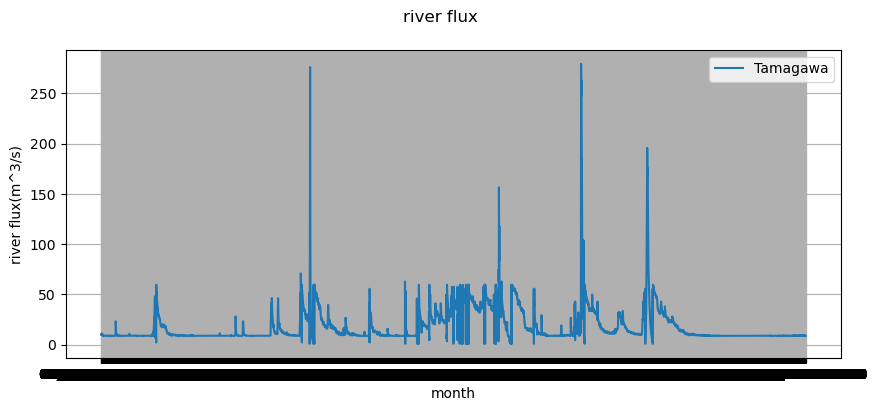

In [42]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1,xlabel='month',ylabel='river flux(m^3/s)')
#ax.plot(flux['Arakawa'][:],label='Arakawa')
#ax.plot(flux['Edogawa'][:],label='Edogawa')
ax.plot(flux['Tamagawa'][:],label='Tamagawa')
#ax.plot(flux['Tsurumigawa'][:],label='Tsurumigawa')
plt.suptitle('river flux')
#plt.ylim(0,400)
plt.plot();ax.legend();ax.grid()
plt.show()

[12.746695951999977, 10.583143565427777, 10.311009491500045, 31.594491735166613, 12.29176813925558, 20.910201746233273, 58.267168852294574, 26.731423447616788, 33.94799390082761, 41.36076616257769, 9.723403896016636, 8.790989432633394]


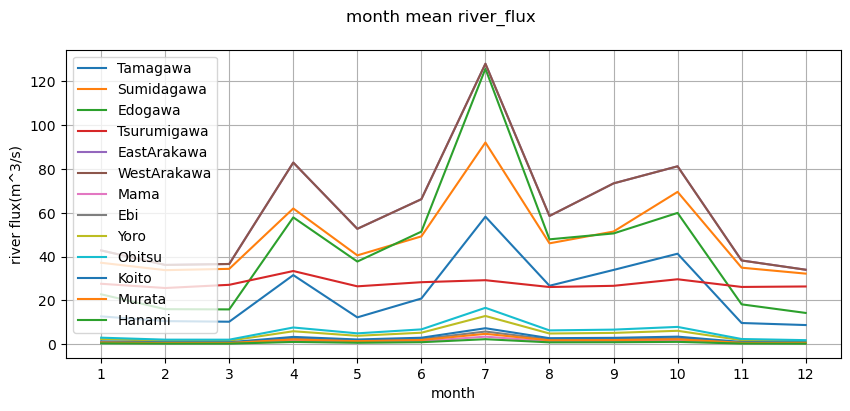

In [58]:
import matplotlib.pyplot as plt
month_river = []
for river in flux.columns:
    month_eachriver=[]
    fl = flux[river]
    for i in range(12):
        st = 24*30*i
        month = sum(fl[st:st+24*30])/(24*30)
        month_eachriver.append(month)
    month_river.append(month_eachriver)
#print(month_river)
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1,xlabel='month',ylabel='river flux(m^3/s)')
for i,river in enumerate(flux.columns):
    ax.plot(month_river[i],label=river)
    i+=1
print(month_river[0])
fig.suptitle('month mean river_flux')
plt.plot();ax.legend();plt.xticks([i for i in range(12)], [i for i in range(1,13)]);ax.grid()
plt.show()

## 平水流量の算出 

## confirm netCDF input file 

In [35]:
import netCDF4
import matplotlib.pyplot as plt
nc = netCDF4.Dataset('C:/Users/ishid/fvcominputs/input/TokyoBay_river.nc','r')
nc.variables.keys()

dict_keys(['river_names', 'time', 'Itime', 'Itime2', 'Times', 'river_flux', 'river_temp', 'river_salt'])

In [36]:
river = nc.variables['river_flux'][:][0].data
river

array([ 9.903056  , 26.521294  ,  3.7485394 , 32.83178   ,  4.0080495 ,
        0.8139498 ,  1.356583  ,  3.0116143 ,  3.8798275 ,  1.7092947 ,
        1.1123981 ,  0.54263324], dtype=float32)

In [37]:
time = nc.variables['time'][:].data
time

array([58849.   , 58849.043, 58849.082, ..., 59214.875, 59214.918,
       59214.957], dtype=float32)

## 公共用水域との比較 

In [72]:
df_kokyo = pd.read_csv('../../kokyo/csv/kokyo2020_Tokyo.csv',encoding='shift-jis',
                       usecols = ['河川名','地点名','採取年月日','採取時刻','流量'])
df_kokyo = df_kokyo.dropna(subset=['流量'])
df_kokyo = df_kokyo.reset_index(drop=True)
df_kokyo['date'] = [dt.strptime(str(df_kokyo['採取年月日'][i]+df_kokyo['採取時刻'][i][0:2]),'%Y/%m/%d%H') 
                    for i in range(len(df_kokyo))] 
print(df_kokyo['date'])

0      2020-04-08 08:00:00
1      2020-04-08 11:00:00
2      2020-05-13 08:00:00
3      2020-05-13 11:00:00
4      2020-06-03 17:00:00
               ...        
1138   2021-01-12 15:00:00
1139   2021-02-09 11:00:00
1140   2021-02-09 15:00:00
1141   2021-03-09 09:00:00
1142   2021-03-09 13:00:00
Name: date, Length: 1143, dtype: datetime64[ns]


In [73]:
place = list(set(df_kokyo['地点名']))
river = list(set(df_kokyo['河川名']))
print(place,river)

['内匠橋', '西川橋（秋川合流点前）', '根岸橋', '報恩橋（多摩川合流点前）', '玉川橋（多摩川合流点前）', '麻生橋（都県境）', '多摩水道橋', '東中野橋', '天神橋', '緑橋（区市境）', '鷲宮橋', '葛三橋（中川合流点前）', '拝島橋', '立川橋（多摩川合流点前）', '神宝大橋（都県境）', '和田見橋', '氷川小橋（多摩川合流点前）', '一休橋', '関戸橋', '台橋', '新葛飾橋', '上日向橋', '中央道北浅川橋（南浅川合流点前）', '飯塚橋', '田園調布堰上（調布取水堰）', '天神森橋', '清柳橋（都県境）', '日野橋', '梅坂橋（柳瀬川合流点前）', '虎狛橋', '多摩川合流点前', '金子橋（都県境）', '別荘橋', '落合橋（成木川合流点前）', '第三京浜多摩川橋', '沢戸橋', '両郡橋（都県境）', '鎌田橋', '和田橋', '落合橋（白子川口）', '桑袋大橋', '新橋（秋川合流点前）', '多摩川原橋', '五反田橋（浅川合流点前）', '下谷橋（黒目川合流点前）', '下田橋下（多摩川合流点前）', '長沼橋下（さいかち堰）', '芝宮橋（都県境）', '多西橋（多摩川合流点前）', '徳丸橋', '落合橋', '兵庫橋（多摩川合流点前）', '鶴間一号橋（都県境）', '東秋川橋（多摩川合流点前）', '川口川橋（浅川合流点前）', '落合橋（北小曽木川合流点前）', '高幡橋（多摩川合流点前）', '春日橋（浅川合流点前）', '都橋（都県境）', '横川橋（浅川合流点前）', '調布橋', '御室橋（南浅川合流点前）'] ['落合川', '三沢川', '残堀川', '仙川', '谷地川', '秋川', '新河岸川', '浅川', '城山川', '程久保川', '大栗川', '白子川', '北秋川', '川口川', '平井川', '綾瀬川', '鶴見川', '江戸川', '柳瀬川', '日原川', '湯殿川', '空堀川', '妙正寺川', '境川', '中川', '恩田川', '養沢川', '案内川', '毛長川', '黒目川', '南浅川', '石神井川', '野川', '大場川', '神田川', '根川', '成木川', '霞川', '黒沢川', '多摩川']

In [74]:
Tama = df_kokyo[df_kokyo['地点名'] ==  '田園調布堰上（調布取水堰）']
Edo = df_kokyo[df_kokyo['地点名'] ==  '新葛飾橋']
print(Tama,Edo)

     河川名            地点名       採取年月日   採取時刻     流量                date
399  多摩川  田園調布堰上（調布取水堰）  2020/04/08  08:15  31.90 2020-04-08 08:00:00
400  多摩川  田園調布堰上（調布取水堰）  2020/04/08  20:10  31.90 2020-04-08 20:00:00
401  多摩川  田園調布堰上（調布取水堰）  2020/05/13  08:33  34.94 2020-05-13 08:00:00
402  多摩川  田園調布堰上（調布取水堰）  2020/05/13  20:42  31.90 2020-05-13 20:00:00
403  多摩川  田園調布堰上（調布取水堰）  2020/06/03  08:25  34.94 2020-06-03 08:00:00
404  多摩川  田園調布堰上（調布取水堰）  2020/06/03  20:05  34.94 2020-06-03 20:00:00
405  多摩川  田園調布堰上（調布取水堰）  2020/07/21  08:20  75.08 2020-07-21 08:00:00
406  多摩川  田園調布堰上（調布取水堰）  2020/07/21  20:19  67.12 2020-07-21 20:00:00
407  多摩川  田園調布堰上（調布取水堰）  2020/08/05  08:50  71.09 2020-08-05 08:00:00
408  多摩川  田園調布堰上（調布取水堰）  2020/08/05  20:35  67.12 2020-08-05 20:00:00
409  多摩川  田園調布堰上（調布取水堰）  2020/09/02  08:17  37.98 2020-09-02 08:00:00
410  多摩川  田園調布堰上（調布取水堰）  2020/09/02  20:23  37.98 2020-09-02 20:00:00
411  多摩川  田園調布堰上（調布取水堰）  2020/10/07  08:10  34.94 2020-10-07 08:00:00
412  多摩川  田園調布堰上（調布取